<h1 style="font-family:Impact,Arial;font-size:50px">Sanity check MWATS export from VAST</h1>
<p> The raw flux measurements are extracted form the VAST pipeline - this script checks that measurements presented in previous papers are reproduced in the latest analysis. 

The light-curves generated for the Bell et al. 2016, 2018 were created using a different algorithm with different filtering, however the main disribution of points should approximately be the same. 

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # the stats module which contains state space modelling

In [2]:
def distance_from_median_pos(df):
    degrees_to_radians = np.pi/180.0
    phi1 = df.ra*degrees_to_radians
    phi2 = df.med_ra*degrees_to_radians

    theta1 = df.dec*degrees_to_radians
    theta2 = df.med_dec*degrees_to_radians
    
    cosine = (np.cos(phi1)*np.cos(phi2)*np.cos(theta1 - theta2) +
           np.sin(phi1)*np.sin(phi2))
    dist_from_centre = np.arccos(cosine)
    return (dist_from_centre/3.142)*180

## Load the data

In [3]:
%%time
# Load the raw data file.
raw_data = pd.read_feather('mwats_raw_data_Feb_SQL.fth')
#raw_data = raw_data.sort('jd')

/Users/134393/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


CPU times: user 3.24 s, sys: 8.14 s, total: 11.4 s
Wall time: 28.4 s


# GLEAM J041022-523247

In [4]:
import json
import matplotlib.pyplot as plt
source = 29267.0
source_data = raw_data[raw_data.source_id == source]
file = '../sanity_check/GLEAM_J041022-523247.txt'
source = json.load(open(file))
fluxes = source['peak_flux']
errors = source['s_error']
s_time = source['jd_time']

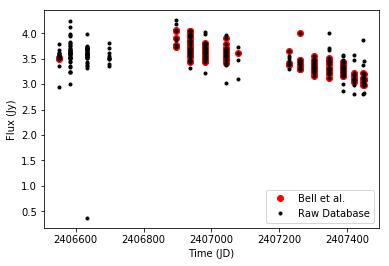

In [5]:
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

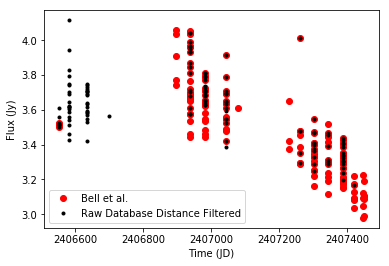

In [6]:
# Plot with distance filtering
source_filt = source_data[source_data.distance < 15.0]
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_filt.jd-50000, source_filt.raw_peak_flux, 'k.', label='Raw Database Distance Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

In [7]:
source_data['med_ra']      = np.median(source_data.ra)
source_data['med_dec']     = np.median(source_data.dec)
source_data['mean_flux']   = np.mean(source_data.raw_peak_flux)
source_data['flux_offset'] = distance_from_median_pos(source_data)
fil_source1 = source_filt[source_filt.flux_offset < (2.0/60)] # Approximately 1 arc minute in Bell et al. 2018
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
#plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.plot(fil_source1.jd-50000, fil_source1.raw_peak_flux, 'k.', label='Raw Database Image and Offset Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

AttributeError: 'DataFrame' object has no attribute 'flux_offset'

# J0953+0755

In [ ]:
interesting = raw_data[ (raw_data.ra > 148.0) & (raw_data.ra < 148.5) & (raw_data.dec < 8.0) & (raw_data.dec > 7.0)]

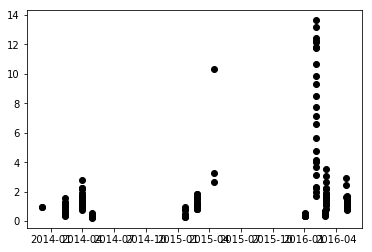

In [25]:
J0953 = raw_data[raw_data.source_id==243604.0]
plt.plot(J0953.time, J0953.raw_peak_flux, 'ko')

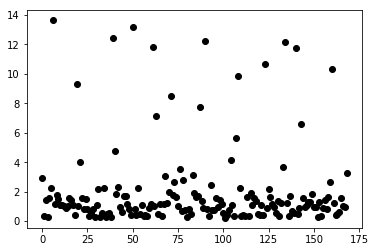

In [26]:
plt.plot(list(J0953.raw_peak_flux), 'ko')

In [38]:
def plot_models(df, aic, models, burn):
    fig_1 , ax = plt.subplots(figsize=(13,10))
    for n in range(4): 
        plt.subplot(2,2,n+1)
        m = sm.tsa.UnobservedComponents(df, models[n])
        m_fit = m.fit()
        plt.plot(range(len(df)), df, label='Observations') # plots the original series
        predict_results = m_fit.get_prediction() # create one step ahead predictions using the Kalman filter
        predict_plot = predict_results.predicted_mean[burn:]
        plt.plot(range(len(predict_plot)), predict_plot, label='One-step ahead prediction')
        plt.title(models[n]+' AIC='+aic[n])
        plt.ylabel('Flux (Jy)')
        plt.xlabel('Time-series (#)')
    

In [32]:
J0953.index = pd.to_datetime(J0953.time)
J0953 = J0953.sort_values(by='jd')
df = J0953.iloc[:, 15]
df.head()

time
2013-12-07 07:03:31.000000    0.988842
2013-12-07 07:09:31.000000    0.928762
2014-02-11 03:01:31.000000    0.458272
2014-02-11 03:07:30.000009    0.380216
2014-02-11 03:13:30.000008    0.420981
Name: raw_peak_flux, dtype: float64

/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associ

local level


/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associ

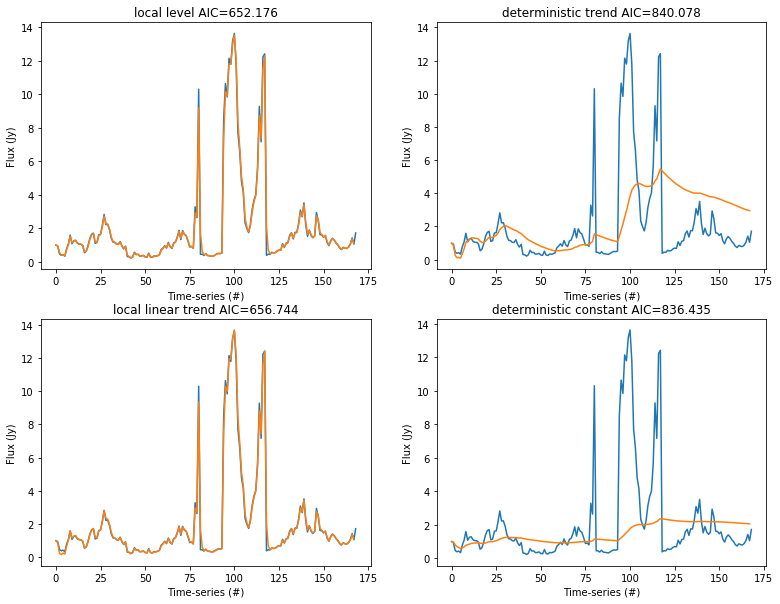

In [33]:
# Test State Space Model
best_model = []
aic = []
models = ['local level', 'deterministic trend', 'local linear trend', 'deterministic constant']
for model in models:
    level_model = sm.tsa.UnobservedComponents(df, model)
    level_results = level_model.fit()
    out = level_results.summary()
    parse = out.as_text()
    parse = parse.split()

    param = parse[parse.index('AIC') + 1]
    aic.append(param)
    best_model.append(float(param))

pref_model = models[(best_model.index(min(best_model)))]
print(pref_model)
plot_models(df, aic, models, burn=1)

/Users/134393/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


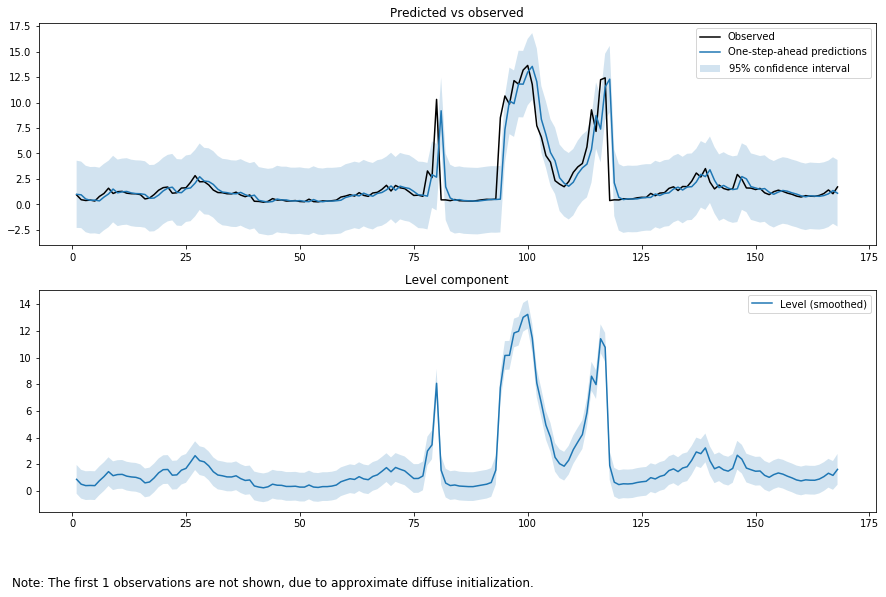

In [55]:
level_model = sm.tsa.UnobservedComponents(df, 'llevel', stochastic=True)
level_results = level_model.fit()
fig = level_results.plot_components(figsize=(15, 9));

# GLEAM J032320+053413

In [45]:
interesting = raw_data[ (raw_data.ra > 50.0) & (raw_data.ra < 51.0) & (raw_data.dec < 6.0) & (raw_data.dec > 5.0)]

In [48]:
source = 237262.0
source_data = raw_data[raw_data.source_id == source]
file = '../sanity_check/GLEAM_J032320+053413.txt'
source = json.load(open(file))
fluxes = source['peak_flux']
errors = source['s_error']
s_time = source['jd_time']

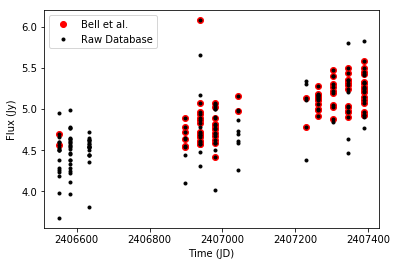

In [49]:
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

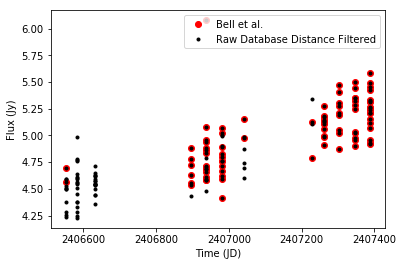

In [50]:
# Plot with distance filtering
source_filt = source_data[source_data.distance < 15.0]
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
plt.plot(source_filt.jd-50000, source_filt.raw_peak_flux, 'k.', label='Raw Database Distance Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

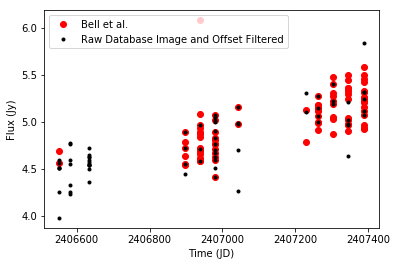

In [57]:
source_data['med_ra']      = np.median(source_data.ra)
source_data['med_dec']     = np.median(source_data.dec)
source_data['mean_flux']   = np.mean(source_data.raw_peak_flux)
source_data['flux_offset'] = distance_from_median_pos(source_data)
fil_source1 = source_data[source_data.flux_offset < (0.0/60)] # Approximately 1 arc minute in Bell et al. 2018
plt.plot(s_time, fluxes, 'ro', label='Bell et al.')
#plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.plot(fil_source1.jd-50000, fil_source1.raw_peak_flux, 'k.', label='Raw Database Image and Offset Filtered')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

In [5]:
source = 39570
source_data = raw_data[raw_data.source_id == source]

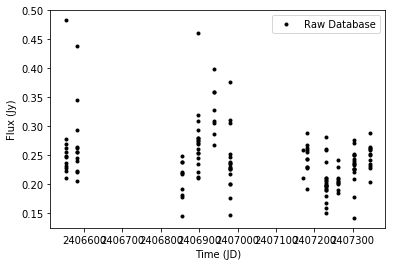

In [6]:
plt.plot(source_data.jd-50000, source_data.raw_peak_flux, 'k.', label='Raw Database')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (Jy)')
plt.legend()

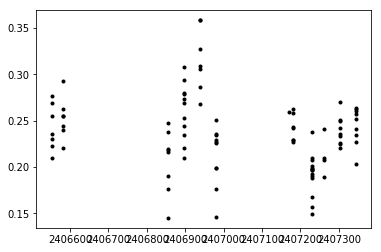

In [8]:
source_filt = source_data[source_data.distance < 12.0]
plt.plot(source_filt.jd-50000, source_filt.raw_peak_flux, 'k.', label='Raw Database Distance Filtered')

In [9]:
source_data['med_ra']      = np.median(source_data.ra)
source_data['med_dec']     = np.median(source_data.dec)
source_data['mean_flux']   = np.mean(source_data.raw_peak_flux)
source_data['flux_offset'] = distance_from_median_pos(source_data)
fil_source1 = source_data[source_data.flux_offset < (0.0/60)] # Approximately 1 arc minute in Bell et al. 2018

/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/134393/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

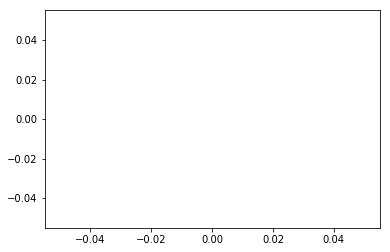

In [10]:
plt.plot(fil_source1.jd-50000, fil_source1.raw_peak_flux, 'k.', label='Raw Database Image and Offset Filtered')

In [5]:
raw_data.head()

,level_0,index,id,source_id,image_id,good_fit,ra,err_ra,dec,err_dec,...,raw_peak_flux,err_raw_peak_flux,rms,time,jd,cube_id,im_ra,im_dec,datetime,distance
0,0,0,3455382,682.0,1377,True,0.357201,0.004489,-76.137436,0.000268,...,3.033476,0.442940,94.316145,2014-08-27 02:50:50,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,26.414775
1,1,1,3456017,7646.0,1377,True,322.430343,0.002180,-64.522869,0.000132,...,1.063937,0.076981,94.316145,2014-08-27 02:50:50,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,23.132906
2,2,2,3458910,48221.0,1377,True,336.831288,0.000779,-45.083741,0.000044,...,1.672887,0.042836,94.316145,2014-08-27 02:50:50,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,11.857082
3,3,3,3456185,11575.0,1377,True,327.948364,0.006504,-61.402412,0.000307,...,0.405364,0.073097,94.316145,2014-08-27 02:50:50,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,17.057009
4,4,4,3459180,58916.0,1377,True,357.668152,0.013615,-42.133575,0.000458,...,0.438988,0.108827,94.316145,2014-08-27 02:50:50,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,18.690365


In [11]:
tmp = raw_data.groupby('source_id')[['ra','dec','raw_peak_flux']].median().reset_index() 
tmp.columns = ['source_id', 'median_ra', 'median_dec', 'median_flux']

In [12]:
result = pd.merge(raw_data,
                 tmp[['source_id', 'median_ra', 'median_dec', 'median_flux']],
                 on='source_id')

In [13]:
result.head()

,level_0,index,id,source_id,image_id,good_fit,ra,err_ra,dec,err_dec,...,time,jd,cube_id,im_ra,im_dec,datetime,distance,median_ra,median_dec,median_flux
0,0,0,3455382,682.0,1377,True,0.357201,0.004489,-76.137436,0.000268,...,2014-08-27 02:50:50.000000,2.456896e+06,1380,-15.980634,-55.104575,2014-08-26 16:50:50+00:00,26.414775,0.364983,-76.148023,2.258118
1,13675,13696,3635082,682.0,1424,True,0.409359,0.004265,-76.142502,0.000133,...,2014-08-27 04:38:50.000000,2.456896e+06,1430,11.150403,-55.106923,2014-08-26 18:38:50+00:00,23.491657,0.364983,-76.148023,2.258118
2,61013,61109,9525524,682.0,3349,True,0.360859,0.003616,-76.151562,0.000108,...,2015-08-27 02:42:49.000000,2.457261e+06,3374,-18.248241,-55.108314,2015-08-26 16:42:49+00:00,27.820753,0.364983,-76.148023,2.258118
3,68544,68645,15278402,682.0,5340,True,0.369070,0.003679,-76.150358,0.000082,...,2014-11-18 23:55:37.000008,2.456980e+06,5381,7.902104,-55.101904,2014-11-18 12:55:37.000008+00:00,22.286283,0.364983,-76.148023,2.258118
4,83624,83780,10942928,682.0,3774,True,0.365077,0.003849,-76.151153,0.000164,...,2013-09-17 02:18:39.000000,2.456552e+06,3801,-3.060629,-55.101688,2013-09-16 16:18:39+00:00,21.314719,0.364983,-76.148023,2.258118


In [ ]:
data['med_ra']      = np.median(source_data.ra)
data['med_dec']     = np.median(source_data.dec)
data['mean_flux']   = np.mean(source_data.raw_peak_flux)
data['flux_offset'] = distance_from_median_pos(source_data)